In [1]:
!pip3 install torch

In [2]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 8.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 8.3 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim

from torchvision import transforms, models
from torch.utils.data import DataLoader
from datasets import load_dataset

In [4]:
# Load dataset
train_dataset = load_dataset('Falah/Alzheimer_MRI', split='train')
test_dataset = load_dataset('Falah/Alzheimer_MRI', split='test')

# Define data transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=3),
    transforms.ToTensor(),
])

# Dataset class to apply transformations
class AlzheimerMRIDataset(torch.utils.data.Dataset):
    def __init__(self, hf_dataset, transform):
        self.hf_dataset = hf_dataset
        self.transform = transform

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        # Load image and label
        item = self.hf_dataset[idx]
        image = item["image"]
        label = item["label"]
        image = self.transform(image)  # Apply transformation

        return image, label

# Convert to PyTorch datasets
train_data = AlzheimerMRIDataset(train_dataset, transform)
test_data = AlzheimerMRIDataset(test_dataset, transform)

# Create DataLoader
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
test_loader = DataLoader(test_data, batch_size=64, shuffle=False)


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/2.13k [00:00<?, ?B/s]

(…)-00000-of-00001-c08a401c53fe5312.parquet:   0%|          | 0.00/22.6M [00:00<?, ?B/s]

(…)-00000-of-00001-44110b9df98c5585.parquet:   0%|          | 0.00/5.65M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/5120 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1280 [00:00<?, ? examples/s]

In [5]:
# Set device for training
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load pre-trained VGG16 model
model = models.vgg16(pretrained=True)

# Adjust the output layer
num_features = model.classifier[6].in_features
model.classifier[6] = nn.Linear(num_features, 4)

model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=3e-4, weight_decay=1e-3)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:04<00:00, 123MB/s]


In [6]:
from sklearn.metrics import f1_score, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

epochs = 15
train_losses, test_losses = [], []
train_accuracies, test_accuracies = [], []

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # Training loop
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)

        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate training accuracy
    train_accuracy = correct / total
    epoch_train_loss = running_loss / len(train_loader)
    train_losses.append(epoch_train_loss)
    train_accuracies.append(train_accuracy)

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")

    # Test
    model.eval()
    test_loss = 0.0
    test_correct = 0
    test_total = 0
    epoch_labels = []
    epoch_preds = []

    with torch.no_grad():
        for inputs, labels in test_loader:  # Test data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)

            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            test_total += labels.size(0)
            test_correct += (predicted == labels).sum().item()

            epoch_labels.extend(labels.cpu().numpy())
            epoch_preds.extend(predicted.cpu().numpy())

    # Calculate accuracy and loss
    test_accuracy = test_correct / test_total
    epoch_test_loss = test_loss / len(test_loader)
    test_losses.append(epoch_test_loss)
    test_accuracies.append(test_accuracy)

    print(f"Test Loss: {epoch_test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")


Epoch 1/15, Train Loss: 1.0643, Train Accuracy: 0.4805
Test Loss: 0.9784, Test Accuracy: 0.5320
Epoch 2/15, Train Loss: 0.9284, Train Accuracy: 0.5611
Test Loss: 0.9070, Test Accuracy: 0.5820
Epoch 3/15, Train Loss: 0.8375, Train Accuracy: 0.6127
Test Loss: 0.8941, Test Accuracy: 0.6156
Epoch 4/15, Train Loss: 0.7620, Train Accuracy: 0.6582
Test Loss: 0.8607, Test Accuracy: 0.6188
Epoch 5/15, Train Loss: 0.6497, Train Accuracy: 0.7164
Test Loss: 0.7601, Test Accuracy: 0.6813
Epoch 6/15, Train Loss: 0.5133, Train Accuracy: 0.7826
Test Loss: 0.6217, Test Accuracy: 0.7844
Epoch 7/15, Train Loss: 0.4069, Train Accuracy: 0.8420
Test Loss: 0.4865, Test Accuracy: 0.8180
Epoch 8/15, Train Loss: 0.2971, Train Accuracy: 0.8840
Test Loss: 0.3821, Test Accuracy: 0.8625
Epoch 9/15, Train Loss: 0.1847, Train Accuracy: 0.9316
Test Loss: 0.6369, Test Accuracy: 0.7961
Epoch 10/15, Train Loss: 0.1193, Train Accuracy: 0.9572
Test Loss: 0.3904, Test Accuracy: 0.8961
Epoch 11/15, Train Loss: 0.1208, Train 

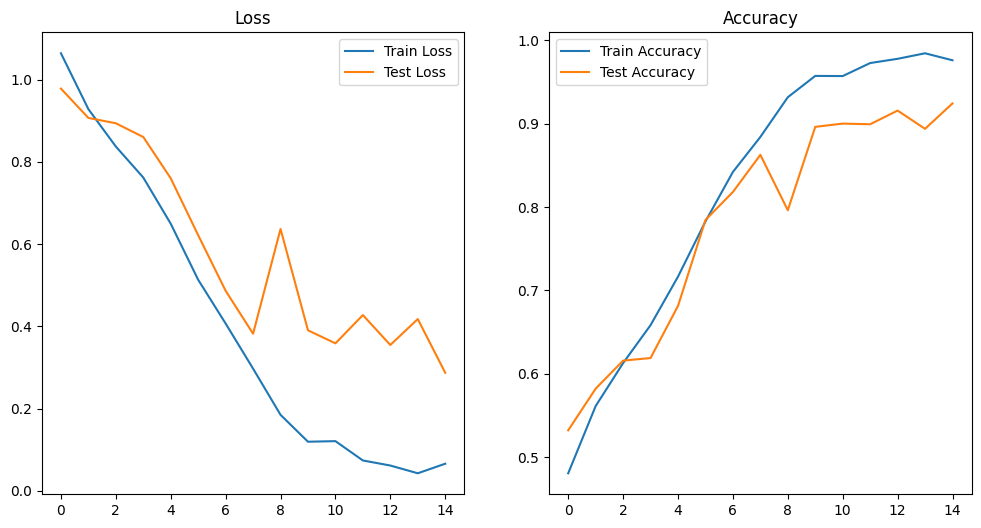

F1 Score: 0.9235
Accuracy: 0.9242


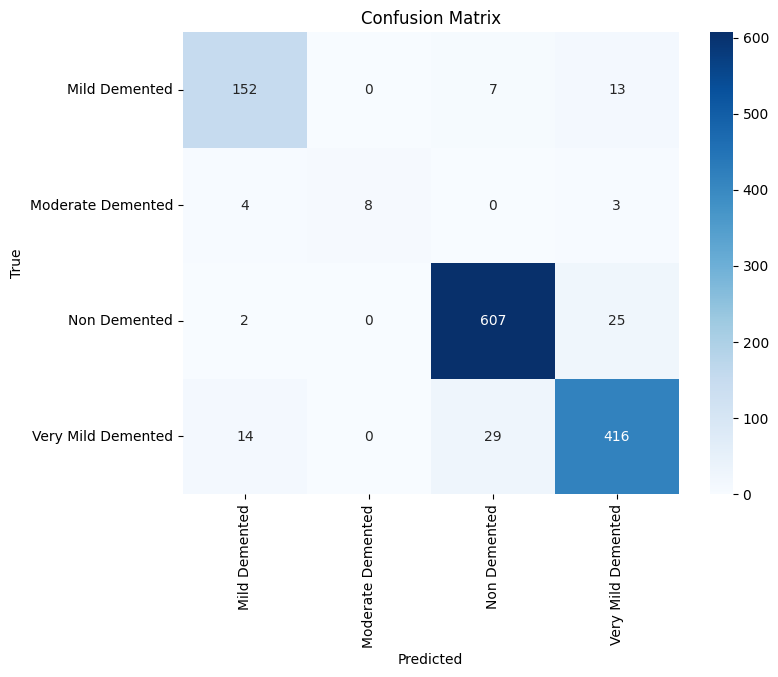

In [7]:
# Plot Training and Test Loss/Accuracy
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.legend()
plt.title('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.legend()
plt.title('Accuracy')

plt.show()

# F1 Score
f1 = f1_score(epoch_labels, epoch_preds, average='weighted')
print(f"F1 Score: {f1:.4f}")

# Accuracy
print(f"Accuracy: { test_accuracies[-1]:.4f}")

# Confusion Matrix
cm = confusion_matrix(epoch_labels, epoch_preds)

labels = ["Mild Demented", "Moderate Demented", "Non Demented", "Very Mild Demented"]
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()